# Análise do Portfolio de Fundos

### Inicializações

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style("whitegrid")


In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')
exchange_rates.head()

,USD2EUR
Date,
2022-07-27,0.98091
2022-07-26,0.98721
2022-07-25,0.97826
2022-07-24,0.97924
2022-07-23,0.97917


In [3]:
#Get the Portofolio
portfolio_csv = 'portofolio.csv'
df_portofolio = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
code2name_dict = {x[0]:x[1] for x in df_portofolio.itertuples()}
df_portofolio.sort_values(by="Nome", axis=0)

,Nome,Moeda,Quantidade
Code,,,
LU0171309270,BGF Healthscience E2 EUR,EUR,76.8300
LU0171310955,BGF Wor Techn EUR E,EUR,30.2400
LU0355585513,JPF Africa Equity D,EUR,14.7020
IE00BLP5S353,Jupiter Glb Abs Rt,USD,15864.5900
LU0094557526,MFS European Research A1 EUR,EUR,23.6460
LU0121204431,NN Glb Sustain Eq,EUR,9.0650
PTSQUGHM0007,Property Core Real Estate,EUR,1901.7213
LU0248173006,SIC Asia B accum EUR,EUR,105.4200
LU0244354824,SIC China opp B USD,USD,7.9000


In [4]:
#Get the historical quotes 

xls = 'historico_cotacoes.xlsx'
dict_df = pd.read_excel(xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all.dropna()

#Create a DataFrame with the daily growth
df_grow = df.apply(lambda x: x/x.shift(-1), axis=0).dropna()

df_all.head()

,IE00BLP5S353,LU0121204431,LU0122613903,LU0171310955,LU0355585513,LU0094557526,LU0171309270,LU0244354824,LU0248173006,PTSQUGHM0007
Date,,,,,,,,,,
2022-07-28,1.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-27,1.31,512.52,NaN,NaN,83.30,44.00,NaN,374.45,42.68,NaN
2022-07-26,1.31,499.09,NaN,49.18,83.20,43.63,54.83,373.78,42.50,10.53
2022-07-25,1.31,500.82,NaN,49.40,82.07,43.75,54.20,372.43,42.12,10.53
2022-07-22,1.31,501.36,NaN,50.35,83.30,43.68,54.26,375.90,42.72,10.53


In [5]:
# Calculate the Portofolio Std and Growth
df_portofolio['STD'] = df_grow.std(axis=0)
df_portofolio['Growth'] = df.apply(lambda x: x[0]/x[-1]-1)
df_portofolio['Racio'] = df_portofolio['Growth']/df_portofolio['STD']

In [6]:
# Get the Current Total Amount in EUR

last_date = min(df_all.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date][0]
# Get the last Quotes
quotes = df_all.fillna(method='bfill').iloc[0]

df_portofolio['Amount EUR'] = df_portofolio['Moeda'].apply(lambda x: usd2eur if x == 'USD' else 1) * quotes * df_portofolio['Quantidade']

sum(df_portofolio['Amount EUR'])

61022.383549788996

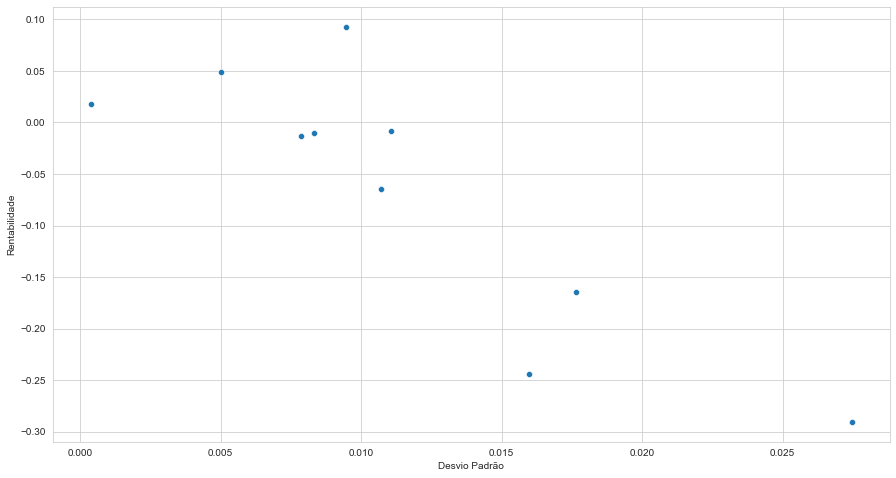

In [7]:
plt.figure(figsize=(15,8))
plt.xlabel('Desvio Padrão')
plt.ylabel('Rentabilidade')
p = sn.scatterplot(x=df_portofolio['STD'],y=df_portofolio['Growth'])

In [8]:
df_portofolio.sort_values(by=['Racio'],ascending=False)

,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
PTSQUGHM0007,Property Core Real Estate,EUR,1901.7213,0.000381,0.017717,46.502031,20025.125289
LU0355585513,JPF Africa Equity D,EUR,14.7020,0.009456,0.092956,9.829869,1224.676600
IE00BLP5S353,Jupiter Glb Abs Rt,USD,15864.5900,0.005023,0.048780,9.711208,20385.872820
LU0121204431,NN Glb Sustain Eq,EUR,9.0650,0.011055,-0.008423,-0.761934,4645.993800
LU0171309270,BGF Healthscience E2 EUR,EUR,76.8300,0.008318,-0.009738,-1.170798,4212.588900
LU0094557526,MFS European Research A1 EUR,EUR,23.6460,0.007871,-0.013397,-1.702058,1040.424000
LU0248173006,SIC Asia B accum EUR,EUR,105.4200,0.010702,-0.064720,-6.047649,4499.325600
LU0171310955,BGF Wor Techn EUR E,EUR,30.2400,0.017658,-0.164669,-9.325444,1487.203200
LU0122613903,T Eastern Europe,EUR,32.1960,0.027453,-0.290667,-10.587762,599.489520


<Figure size 1080x576 with 0 Axes>

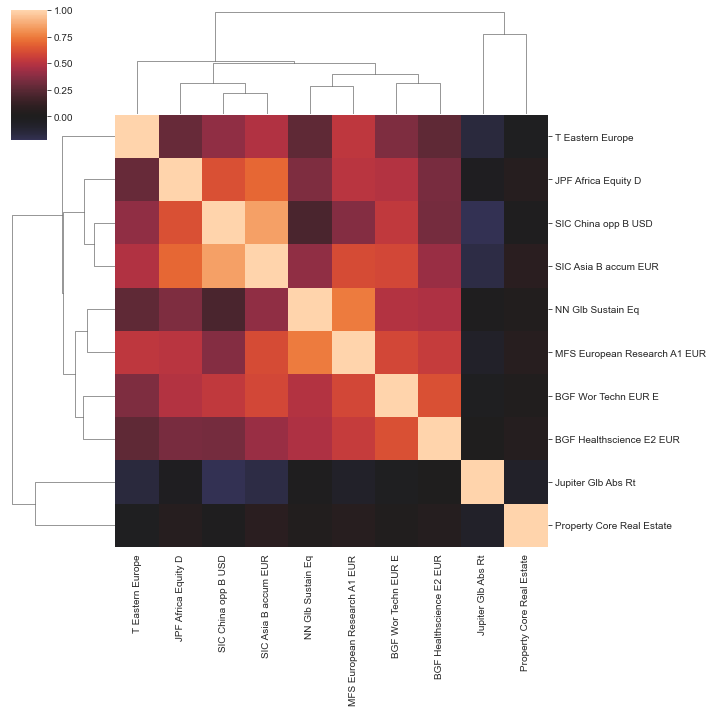

In [9]:
plt.figure(figsize=(15,8))
sn.clustermap(df_grow.rename(columns=code2name_dict).corr(),center=0)
#df_grow.corr()

In [10]:
##### Performance in the last days
df_portofolio_tmp = df_portofolio.copy()
start =60
finish = 0
print('Start Date:',df_all.index[start])
df_portofolio_tmp['Growth'] = df_all.fillna(method='bfill').fillna(method='pad').apply(lambda x: x[finish]/x[start]-1)
df_portofolio_tmp['Racio'] = df_portofolio_tmp['Growth']/df_portofolio_tmp['STD']
df_portofolio_tmp.sort_values(by=['Racio'],ascending=False)

Start Date: 2022-05-05


,Nome,Moeda,Quantidade,STD,Growth,Racio,Amount EUR
Code,,,,,,,
PTSQUGHM0007,Property Core Real Estate,EUR,1901.7213,0.000381,0.007656,20.094019,20025.125289
LU0248173006,SIC Asia B accum EUR,EUR,105.4200,0.010702,0.050455,4.714713,4499.325600
LU0244354824,SIC China opp B USD,USD,7.9000,0.015961,0.070928,4.443961,2901.683821
LU0171309270,BGF Healthscience E2 EUR,EUR,76.8300,0.008318,0.034724,4.174684,4212.588900
LU0121204431,NN Glb Sustain Eq,EUR,9.0650,0.011055,0.042703,3.862743,4645.993800
IE00BLP5S353,Jupiter Glb Abs Rt,USD,15864.5900,0.005023,0.007692,1.531383,20385.872820
LU0122613903,T Eastern Europe,EUR,32.1960,0.027453,0.000000,0.000000,599.489520
LU0094557526,MFS European Research A1 EUR,EUR,23.6460,0.007871,-0.005425,-0.689243,1040.424000
LU0171310955,BGF Wor Techn EUR E,EUR,30.2400,0.017658,-0.062166,-3.520561,1487.203200


Start Date: 2022-05-05


<AxesSubplot:xlabel='Date'>

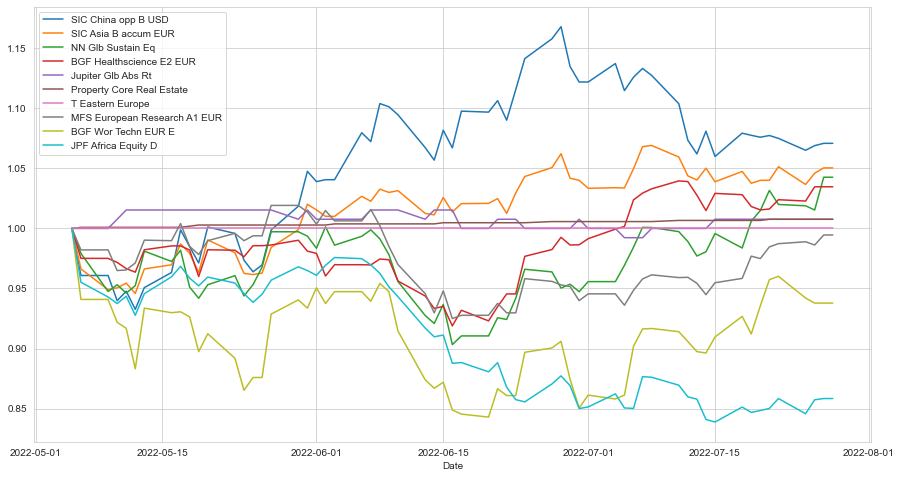

In [11]:
print('Start Date:',df_all.index[start])
df_all_tmp = df_all.fillna(method='bfill').fillna(method='pad').apply(lambda x: x/x[start], axis=0)
df_all_tmp = df_all_tmp.sort_values(by=df_all_tmp.index[finish],axis=1,ascending=False).rename(columns=code2name_dict)
ax = df_all_tmp.iloc[finish:start+1].plot(figsize=(15,8),grid=True)
ax.legend(loc='upper left')
ax

In [12]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

if 'LU0122613903' in dict_df:
    del dict_df['LU0122613903']

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_all = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False)
df = df_all.dropna()

mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
df_w = pd.DataFrame(data = {'all':list(cleaned_weights.values())}, index=list(cleaned_weights.keys()))
df_pp = pd.DataFrame(data = {'all':list(ef.portfolio_performance())}, index=list(['anual return','volatility','sharpe ratio']))
mu_w = 0.25*mu

for n in [10,20,60]:
    mu = mean_historical_return(df[:n].sort_index())
    ef = EfficientFrontier(mu, S)
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    df_w[n] = list(cleaned_weights.values())
    df_pp[n] = list(ef.portfolio_performance())
    mu_w += 0.25*mu

df_w

,all,10,20,60
IE00BLP5S353,0.00000,0.29163,0.19611,0.44435
LU0121204431,0.00000,0.22056,0.16786,0.00000
LU0171310955,0.15552,0.12208,0.00000,0.00000
LU0355585513,0.00000,0.00000,0.00000,0.00000
LU0094557526,0.00000,0.27351,0.00000,0.00000
LU0171309270,0.00000,0.00000,0.54976,0.00000
LU0244354824,0.84448,0.00000,0.00000,0.00000
LU0248173006,0.00000,0.00000,0.00000,0.12378
PTSQUGHM0007,0.00000,0.09222,0.08627,0.43187


In [13]:
df_pp

,all,10,20,60
anual return,0.456568,1.209384,0.734094,0.079616
volatility,0.292770,0.119698,0.105948,0.047463
sharpe ratio,1.491164,9.936539,6.740034,1.256045


In [14]:
ef = EfficientFrontier(mu_w, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
cleaned_weights, ef.portfolio_performance()

(OrderedDict([('IE00BLP5S353', 0.34072),
              ('LU0121204431', 0.45769),
              ('LU0171310955', 0.10456),
              ('LU0355585513', 0.0),
              ('LU0094557526', 0.05751),
              ('LU0171309270', 0.03952),
              ('LU0244354824', 0.0),
              ('LU0248173006', 0.0),
              ('PTSQUGHM0007', 0.0)]),
 (0.4739146893750983, 0.13636305761735554, 3.3287218496435833))